<div style="background-color: #a7d9b6; color: black; padding: 20px">
  <h1 style="text-align: center"><strong>TPE Yann Inas 2023</strong></h1>
  <h2 style="text-align: center"><em>Détection de fraude bancaire</em></h2>
</div>

<!-- Pour le mode sombre -->

<style>
@media (prefers-color-scheme: dark) {
  div {
    background-color: #303030;
    color: white;
  }
}
</style>


# 1. Imports

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pretraitement

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import xgboost as xgb

In [3]:
DATA_x = pd.read_csv('data/X_train_G3tdtEn.csv', delimiter = ',',encoding = 'latin1', low_memory=False)
DATA_y = pd.read_csv('data/Y_train_2_XPXJDyy.csv', delimiter = ',',encoding = 'latin1', low_memory=False)

# 2. Objectifs

Un panier (= une ligne, un ID) peut être constitué de 1 à 24 produits, et pour chaque produit on a 
- *item* : la catégorie du produit 
- *make* : la marque du produit
- *cash_price* : le cout du produit
- *model* : la référence exacte du produit
- *goods_code* : le code barre associé au produit
- *Nbr_of_prod_purchas* : le nombre de produits identiques commandés 
- *Nb_of_items* : le nombre de produits différents dans le panier (de 1 à 24)
- *fraud_flag* : Est-ce que le panier a été jugé frauduleux à postériori

Il faut maintenant choisir quelles classes sont à conserver pour améliorer le modèle. Dans ce notebook, ce sont les classes ``make``, ``cash_price``, ``Nb_of_items``. 

Cependant, nous allons aussi trier dans ces classes ce qui est intéressant de garder.

# 3. Le nombre d'items dans un panier

In [4]:
merged_df = pd.merge(DATA_x,DATA_y,on="ID")
merged_df_fraud = merged_df[merged_df["fraud_flag"] == 1]

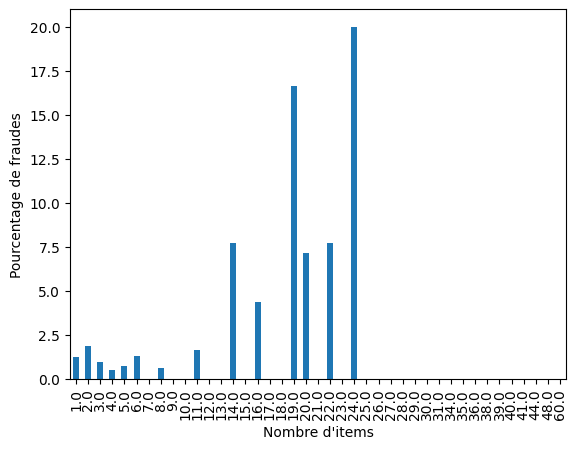

In [5]:
total_counts = merged_df['Nb_of_items'].value_counts()
fraud_counts = merged_df_fraud['Nb_of_items'].value_counts()
fraud_percentages = fraud_counts / total_counts * 100

fraud_percentages.plot(kind='bar')
plt.xlabel("Nombre d'items")
plt.ylabel('Pourcentage de fraudes')
plt.show()

Toujours se méfier avec ces graphiques en pourcentage. On pourrait déduire du graphique ci dessus que les fraudeurs ont tendances à mettre pleins d'items dans leur panier. Mais est-ce vraiment représentatif ? 

In [6]:
# On va regarder si le taux de fraude est supérieur sur les paniers à plus de 5items, que sur la BDD en général

nb_fraudes = 0
nb_achats = 0
for i in [6,8,11,14,16,19,20,22,24]:
    nb_fraudes += merged_df_fraud['Nb_of_items'].value_counts()[i]
    nb_achats += merged_df['Nb_of_items'].value_counts()[i]
    pourcentage = round(100 * nb_fraudes / (nb_fraudes + nb_achats), 2)
    print("     Nombre d'items : ", i, " / nombre d'achats : ", nb_achats, " / nombre de fraudes", nb_fraudes, "(", pourcentage,"%)")

     Nombre d'items :  6  / nombre d'achats :  390  / nombre de fraudes 5 ( 1.27 %)
     Nombre d'items :  8  / nombre d'achats :  549  / nombre de fraudes 6 ( 1.08 %)
     Nombre d'items :  11  / nombre d'achats :  611  / nombre de fraudes 7 ( 1.13 %)
     Nombre d'items :  14  / nombre d'achats :  637  / nombre de fraudes 9 ( 1.39 %)
     Nombre d'items :  16  / nombre d'achats :  660  / nombre de fraudes 10 ( 1.49 %)
     Nombre d'items :  19  / nombre d'achats :  672  / nombre de fraudes 12 ( 1.75 %)
     Nombre d'items :  20  / nombre d'achats :  686  / nombre de fraudes 13 ( 1.86 %)
     Nombre d'items :  22  / nombre d'achats :  699  / nombre de fraudes 14 ( 1.96 %)
     Nombre d'items :  24  / nombre d'achats :  704  / nombre de fraudes 15 ( 2.09 %)


La sortie de la cellule précédente est une addition $ligne_{n+1} = ligne_n + (achats, fraudes, pourcentFraudes)_{n+1}$

### Qu'en déduire ? 
Les paniers à plus de 6items représentent 704 achats sur les ~93000 (0.7% de la database) et représentent 15fraudes sur les 1309 de base (1.1%). Alors certes, le taux de fraudes est très légèrement supérieur au 1.4% de taux de fraudes sur la database entière, mais c'est minime comparé au peu de données. 

Ces informations couplées à des informations obtenus par ``clf.feature_importances_`` pour les RandomForest ou ``xgb.plot_importance`` pour les XGBoost classifiers, qui donnent le poids des caractéristiques dans le modèle, (les colonnes au dessus de 5 ont un poids extrêmement faible) nous conduisent à la décision suivante : **On va uniquement garder les 4 à 5premiers items d'un panier.**

*nb : la précision est la même voir bien moins bonne avec toutes les colonnes, et il y a aussi un aspect important, très concret : le temps de computation. Nous n'avons pas tous des machines de guerre!*

# 4. Quelles marques conserver ? 

### 4.1) Création du dataframe

Premièrement, il faut créer un DataFrame à base de one-hot encoding pour avoir en colonnes :
- l'ID
- les marques présentes dans les 4 premiers items du panier

In [9]:
marques = []
nb_colonnes = 4 #item1-2-3-4

for i in range(1, nb_colonnes+1):
    marques.append(DATA_x['make'+str(i)].astype(str).unique())

tableau_des_marques = np.unique(np.concatenate(marques))
# =========================================================================
df_make = pd.DataFrame(columns=tableau_des_marques, index=DATA_x.index)
df_make['ID'] = DATA_x['ID']

for row in DATA_x.index:
    for i in range(1, nb_colonnes+1):
        marque = DATA_x[f'make{i}'][row]
        nb_items = DATA_x[f"Nbr_of_prod_purchas{i}"][row]

        if type(marque) == float: # Stop si valeur nulle
            break
    
        make_column = f"{marque}"
        if make_column in df_make.columns:
            df_make[make_column][row] = nb_items

df_make = df_make.fillna(0)
df_make.head()

C:\Users\kille\AppData\Local\Temp\ipykernel_13884\71479618.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_make[make_column][row] = nb_items


,4 SEASONS OUTDOOR,4MOMS,AARKE,AB AUDIO,ABC,ACANA,ACCTIM,ACER,ACQUA DI PARMA,ADIDAS,...,WRENDALE DESIGNS,WROUGHT IRON AND BRASS BED CO,WROUGHT IRON AND BRASS BED CO.,YAMAZAKI,YARDART,YVES SAINT LAURENT,YVONNE ELLEN,ZELENS,nan,ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,85517
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,51113
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,83008
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,78712
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,77846


In [42]:
# df_make.to_csv("data/df_make_save.csv", sep = ',',encoding = 'latin1')

### 4.2) Seuillage

Maintenant que notre DataFrame de marques est créé, faisons quelques statistiques pour observer si toutes les marques sont intéressantes à garder, ou non.

In [10]:
# Calculer le nombre total d'achats pour chaque colonne
achats_par_colonne = df_make.sum()

# Filtrer les colonnes qui ont plus de x achats
x_achats = 20
colonnes_plus_de_x_achats = achats_par_colonne[achats_par_colonne > x_achats].index

# Sélectionner uniquement les colonnes qui ont plus de 10 achats
df_plus_de_x_achats = df_make[colonnes_plus_de_x_achats]
print("Nombre de marques qui ont plus de ", x_achats,"achats : ", df_plus_de_x_achats.shape[1]-1, "sur", df_make.shape[1]-1, "marques de base")

Nombre de marques qui ont plus de  20 achats :  98 sur 669 marques de base


In [11]:
merged_plus_x_achats = pd.merge(df_plus_de_x_achats,DATA_y,on='ID')
merged_plus_x_achats_fraud = merged_plus_x_achats[merged_plus_x_achats['fraud_flag'] == 1]

<AxesSubplot: >

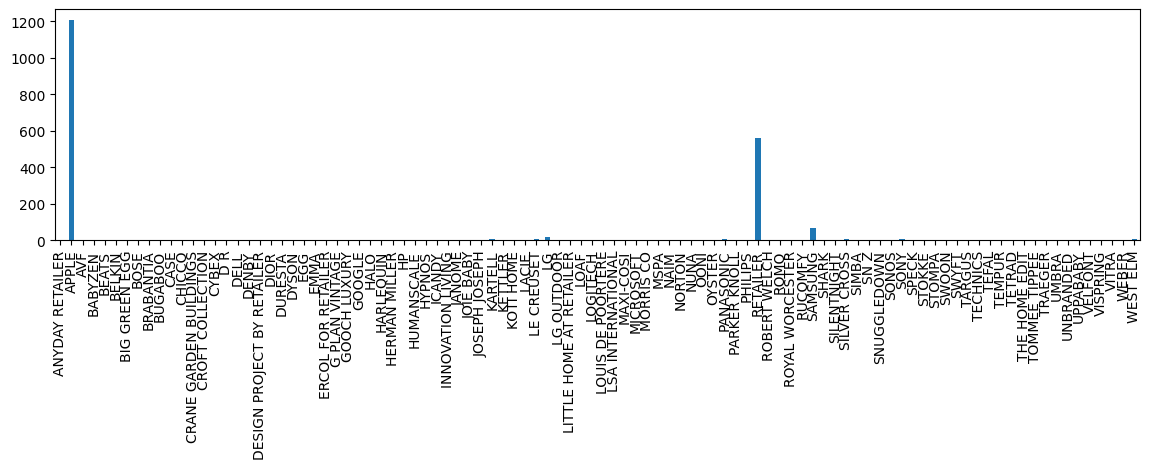

In [12]:
plt.figure(figsize=(14,3))
merged_plus_x_achats_fraud.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum().plot(kind='bar')

*fig : valeur absolue du nombre d'achats par marque* 

<AxesSubplot: >

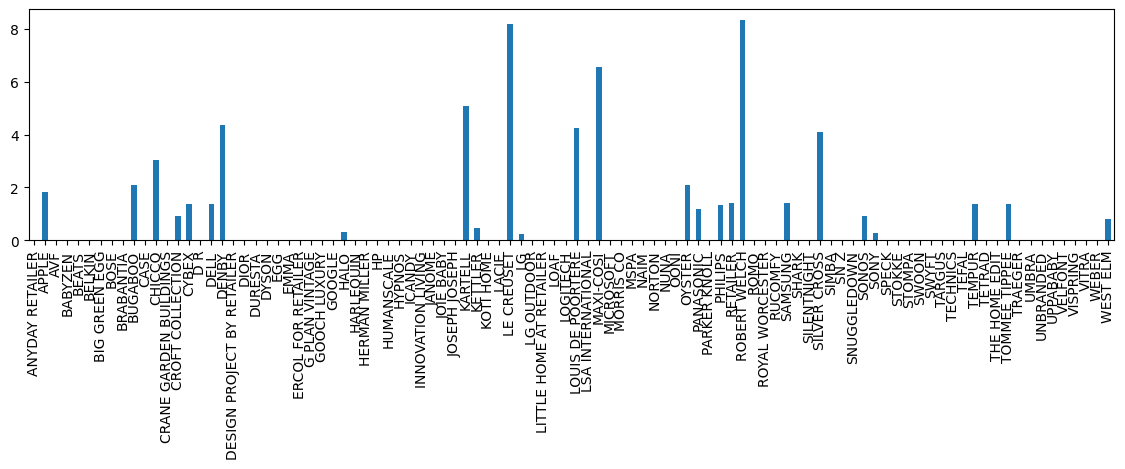

In [13]:
tab1 = merged_plus_x_achats_fraud.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum()
tab2 = merged_plus_x_achats.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum()
tab3 = 100 * tab1 / (tab1 + tab2)
plt.figure(figsize=(14,3))
tab3.plot(kind='bar')

*fig : taux de fraude (nb_achats frauduleux/nb_achats) chez chaque marque* 

In [14]:
marques_frauduleuses_pourcentage = tab3[tab3 > 0.1].index
marques_frauduleuses_absolu = tab1[tab1 > 5].index
print("Nombre de marques qui vendent plus de 20items et qui ont un pourcentage de fraude supérieur à 0.1% :", len(marques_frauduleuses_pourcentage) )

Nombre de marques qui vendent plus de 20items et qui ont un pourcentage de fraude supérieur à 0.1% : 26


Sur les ~700 marques présentes dans le DataFrame original, seulement 26 sont un peu concernées par la fraude. 

Faisons un DataFrame qui contient : 
- Les 26marques intéressantes
- les cash_prices1-2-3-4
- l'ID
- le Nb_of_items

In [15]:
les_fraudes = merged_plus_x_achats[marques_frauduleuses_pourcentage]

les_fraudes['Nb_of_items'] = DATA_x['Nb_of_items']

cash_price_columns = ["cash_price" + str(i) for i in range(1, 5)]
X_cash_price = DATA_x[cash_price_columns]
les_fraudes = pd.concat([les_fraudes, X_cash_price], axis=1)
les_fraudes = les_fraudes.fillna(0)

les_fraudes.head()

C:\Users\kille\AppData\Local\Temp\ipykernel_13884\2901191504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  les_fraudes['Nb_of_items'] = DATA_x['Nb_of_items']


,APPLE,BUGABOO,CHICCO,CROFT COLLECTION,CYBEX,DELL,DENBY,HALO,KARTELL,KETTLER,...,SONOS,SONY,TEMPUR,TOMMEE TIPPEE,WEST ELM,Nb_of_items,cash_price1,cash_price2,cash_price3,cash_price4
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,889.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,409.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1399.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,689.0,119.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1199.0,0.0,0.0,0.0


# Test de modèles

On va faire tourner un modèle XGBoost sur une trentaine de répartitions aléatoires X_train / X_test.

In [16]:
avg_preci = []
confusion = []
for i in range(30):
    X_train, X_test, Y_train, Y_test = train_test_split(les_fraudes, DATA_y, test_size = 0.2)
    Y_train = Y_train.drop("ID",axis=1).drop("index",axis=1)
    Y_test = Y_test.drop("ID", axis=1).drop("index",axis=1)
    boost2 = xgb.XGBClassifier()
    boost2.fit(X_train, Y_train)
    y_pred2 = boost2.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred2).ravel()
    avg_preci.append(average_precision_score(Y_test, y_pred2))
    confusion.append((tn, fp, fn, tp))

In [17]:
print("Moyenne des average precision :", sum(avg_preci)/len(avg_preci))

Moyenne des average precision : 0.054333278314848674


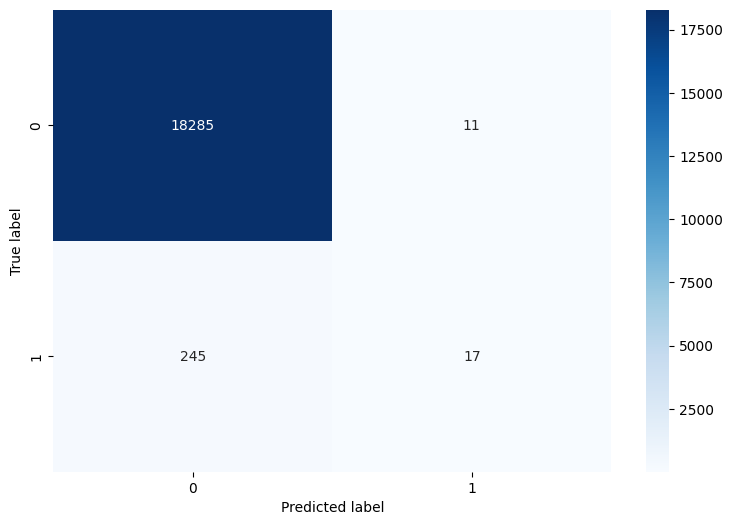

In [41]:
# Calculer la moyenne de chaque élément de la matrice de confusion
avg_confusion = np.mean(confusion, axis=0)

# Créer une matrice de confusion en utilisant la moyenne
confusion_matrix = np.array([[avg_confusion[0], avg_confusion[1]], [avg_confusion[2], avg_confusion[3]]])

# Créer une heatmap à partir de la matrice de confusion
plt.figure(figsize=(9,6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt=".0f")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

On peut voir sur la matrice de confusion que pas mal de fraudes passent entre les mains de notre modèle.

### Comparaison

On peut essayer de comparer avec le DataFrame le plus simple : celui qui ne regarde que les prix des paniers

In [64]:
selection_colonnes = ["cash_price" + str(i) for i in range(1, 5)]
df_prices = DATA_x[selection_colonnes]
df_prices = df_prices.fillna(0)

In [65]:
valeurs_comp = []
for i in range(30):
    X_train, X_test, Y_train, Y_test = train_test_split(df_prices, DATA_y, test_size = 0.2)
    Y_train = Y_train.drop("ID",axis=1).drop("index",axis=1)
    Y_test = Y_test.drop("ID", axis=1).drop("index",axis=1)
    boost2 = xgb.XGBClassifier()
    boost2.fit(X_train, Y_train)
    y_pred2 = boost2.predict(X_test)

    valeurs_comp.append(average_precision_score(Y_test, y_pred2))

In [67]:
print("Moyenne des average precision :", sum(valeurs_comp)/len(valeurs_comp))

Moyenne des average precision : 0.03438678460760448


On a une meilleure précision en ajoutant les marques. 